In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent

from VAE_OPTIMIZATION_WD import _dataset, VAE, study, compare_distributions_binned_aux, compare_distributions_binned

[I 2021-07-22 11:40:03,782] Using an existing study with name 'Optimizing the VAE with WD - BKG vs Random Sampling' instead of creating a new one.


## Loading the Study

In [2]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 68
Best trial:
  Value: 114.97960542613795
  Params: 
    alpha: 2176
    hidden_size: 38
    lr: 9.794650406548094e-05
    n_layers_decoder: 2
    n_layers_encoder: 4
    n_units_decoder_l0: 395
    n_units_decoder_l1: 115
    n_units_encoder_l0: 100
    n_units_encoder_l1: 80
    n_units_encoder_l2: 450
    n_units_encoder_l3: 170
 TRIAL NUMBER: 53


### Optuna Graphs

In [3]:
optuna.visualization.plot_param_importances(study) 

In [4]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [5]:
# Nao é o 49, 53, 33, 26, 25, 23, 22, 16
#name = "wd-sample_vs_data_trial_16"
#name = "wd-sample_vs_data_trial_{}".format(trial.number)
name = "CustomTrain_WD-Data_vs_Sampling_trial_53"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[16], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=80, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=80, out_features=450, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=450, out_features=170, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=170, out_features=38, bias=True)
  )
  (hidden2mu): Linear(in_features=38, out_features=38, bias=True)
  (hidden2log_var): Linear(in_features=38, out_features=38, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=38, out_features=395, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=395, out_features=115, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=115, out_features=69, bias=True)
  )
)

### Load data

In [6]:
# Bkg
bkg = _dataset(category='test',variant='bkg').all_data()
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(341121, 69)

## Check if z ~ N(0,1)

In [7]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(341121, 38)

Mean: -0.47114262 	Std: 0.9668801
Mean: -0.0074573737 	Std: 0.9754694
Mean: 0.19173029 	Std: 0.89873695
Mean: -0.10737782 	Std: 1.1245694
Mean: -0.021979101 	Std: 1.1511208
Mean: -0.03199028 	Std: 0.9659689
Mean: 0.6719596 	Std: 1.1279688
Mean: 0.100720346 	Std: 1.2454513
Mean: 0.19329838 	Std: 1.2060645
Mean: -0.13420711 	Std: 1.0100547
Mean: 0.44054365 	Std: 1.0919558
Mean: -0.022600982 	Std: 0.9682979
Mean: -0.6463282 	Std: 0.8848772
Mean: -0.60434914 	Std: 0.97659385
Mean: 0.25459197 	Std: 1.025212
Mean: -0.34286356 	Std: 1.0924994
Mean: -0.025334718 	Std: 1.1671702
Mean: -0.06239515 	Std: 0.96541953
Mean: -0.16717835 	Std: 1.0810165
Mean: -0.53664327 	Std: 1.0203274
Mean: 0.29937434 	Std: 1.038211
Mean: 0.032651227 	Std: 0.9393581
Mean: 0.0007931066 	Std: 0.8909847
Mean: 0.05268481 	Std: 1.1637735
Mean: -0.69704956 	Std: 1.0362984
Mean: -0.33442447 	Std: 0.74299395
Mean: 0.54973394 	Std: 1.0080543
Mean: 0.10101969 	Std: 1.0349647
Mean: 0.35699666 	Std: 0.92425907
Mean: -0.09392693

<ipython-input-8-2870a7d92efa>:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



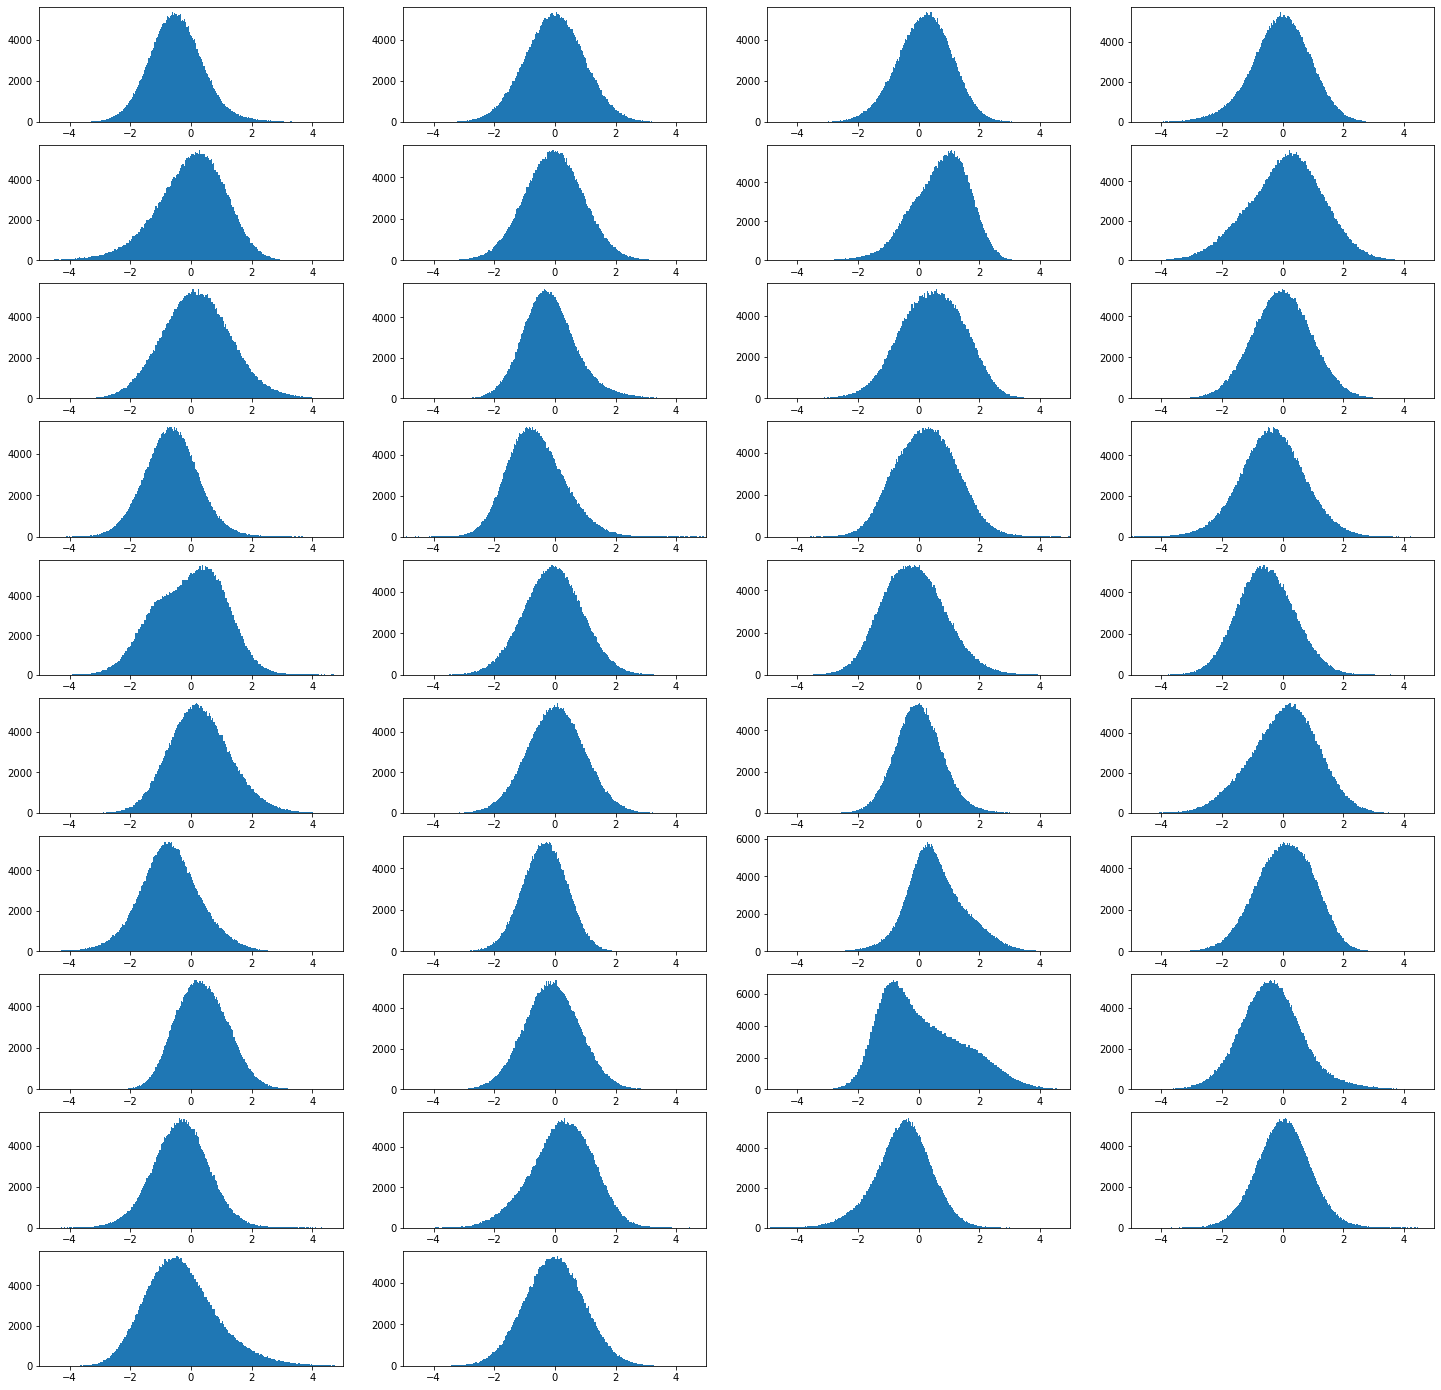

In [8]:

fig = plt.figure(figsize=[25,25])
i = 0

for x in range(hidden.shape[1]):
    axes = fig.add_subplot(10,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())


fig.show()

## Bkg Data vs Random Sampling Decoding

In [9]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

Electron1_Eta   Electron1_PT  Electron1_Phi  Electron2_Eta  \
count  341121.000000  341121.000000  341121.000000  341121.000000   
mean       -0.071992      -0.305917       0.075212      -0.041085   
std         0.188599       0.231176       0.138008       0.173109   
min        -1.225251      -1.009348      -0.835849      -1.442805   
25%        -0.142241      -0.485966      -0.013487      -0.104662   
50%        -0.026259      -0.325151       0.050142      -0.013342   
75%         0.040014      -0.147823       0.136373       0.061591   
max         0.900056       0.834969       1.453977       0.638755   

        Electron2_PT  Electron2_Phi  Electron_Multi    FatJet1_Eta  \
count  341121.000000  341121.000000   341121.000000  341121.000000   
mean       -0.640422       0.047558       -0.445817       0.207197   
std         0.066257       0.137380        0.240314       0.222985   
min        -0.976330      -1.061179       -0.830357      -0.797876   
25%        -0.685200      -0.016509       -0.655716       0.057944   
50%        -0.636301       0.067249       -0.488814       0.209809   
75%        -0.592707       0.135196       -0.284543       0.358083   
max        -0.286350       0.523425        0.821198       1.228839   

        FatJet1_Mass     FatJet1_PT  ...  MissingET_MET  MissingET_Phi  \
count  341121.000000  341121.000000  ...  341121.000000  341121.000000   
mean       -1.110369      -0.912476  ...      -1.327827      -1.041673   
std         0.209218       0.155694  ...       0.297392       0.469227   
min        -1.916914      -1.556085  ...      -2.435818      -2.730107   
25%        -1.254762      -1.017792  ...      -1.535501      -1.384198   
50%        -1.116976      -0.909263  ...      -1.331916      -1.070652   
75%        -0.972304      -0.805222  ...      -1.125909      -0.716328   
max        -0.149709      -0.200652  ...      -0.048267       0.734870   

           Muon1_Eta       Muon1_PT      Muon1_Phi      Muon2_Eta  \
count  341121.000000  341121.000000  341121.000000  341121.000000   
mean       -1.402297      -0.007858      -1.089165      -0.431011   
std         0.335453       0.183371       0.279068       0.293212   
min        -2.675559      -0.689918      -2.202446      -1.736768   
25%        -1.634712      -0.135551      -1.279445      -0.628856   
50%        -1.411135      -0.021664      -1.095060      -0.410486   
75%        -1.180240       0.105544      -0.904788      -0.216448   
max         0.050999       0.908598       0.367238       0.775996   

            Muon2_PT      Muon2_Phi     Muon_Multi    ScalarHT_HT  
count  341121.000000  341121.000000  341121.000000  341121.000000  
mean       -0.535053      -0.231872       0.434959      -0.952371  
std         0.199181       0.324419       0.229031       0.158216  
min        -1.048871      -1.659295      -0.859022      -1.625020  
25%        -0.680059      -0.450379       0.286965      -1.059991  
50%        -0.569909      -0.214123       0.482134      -0.945069  
75%        -0.422996      -0.022775       0.628517      -0.838575  
max         0.833906       1.530831       0.873222      -0.380976  

[8 rows x 69 columns]

In [10]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        #WD_SCORE += wasserstein_distance(background[x], signal[x])
        #R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("WD_SCORE:", WD_SCORE/len(features))
    #print("R2_SCORE:", R2_SCORE/len(features))

In [11]:
plot_graphs2(bkg, sample)

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

In [1]:
print("WD_Score:", compare_distributions_binned(bkg.to_numpy(), bkg_weights.to_numpy(), sample.to_numpy(), np.ones(bkg_weights.shape), bins=100))

NameError: name 'compare_distributions_binned' is not defined

## Bkg Data vs Reconstruction

In [ ]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        #R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("R2_SCORE:", R2_SCORE/num_features)

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

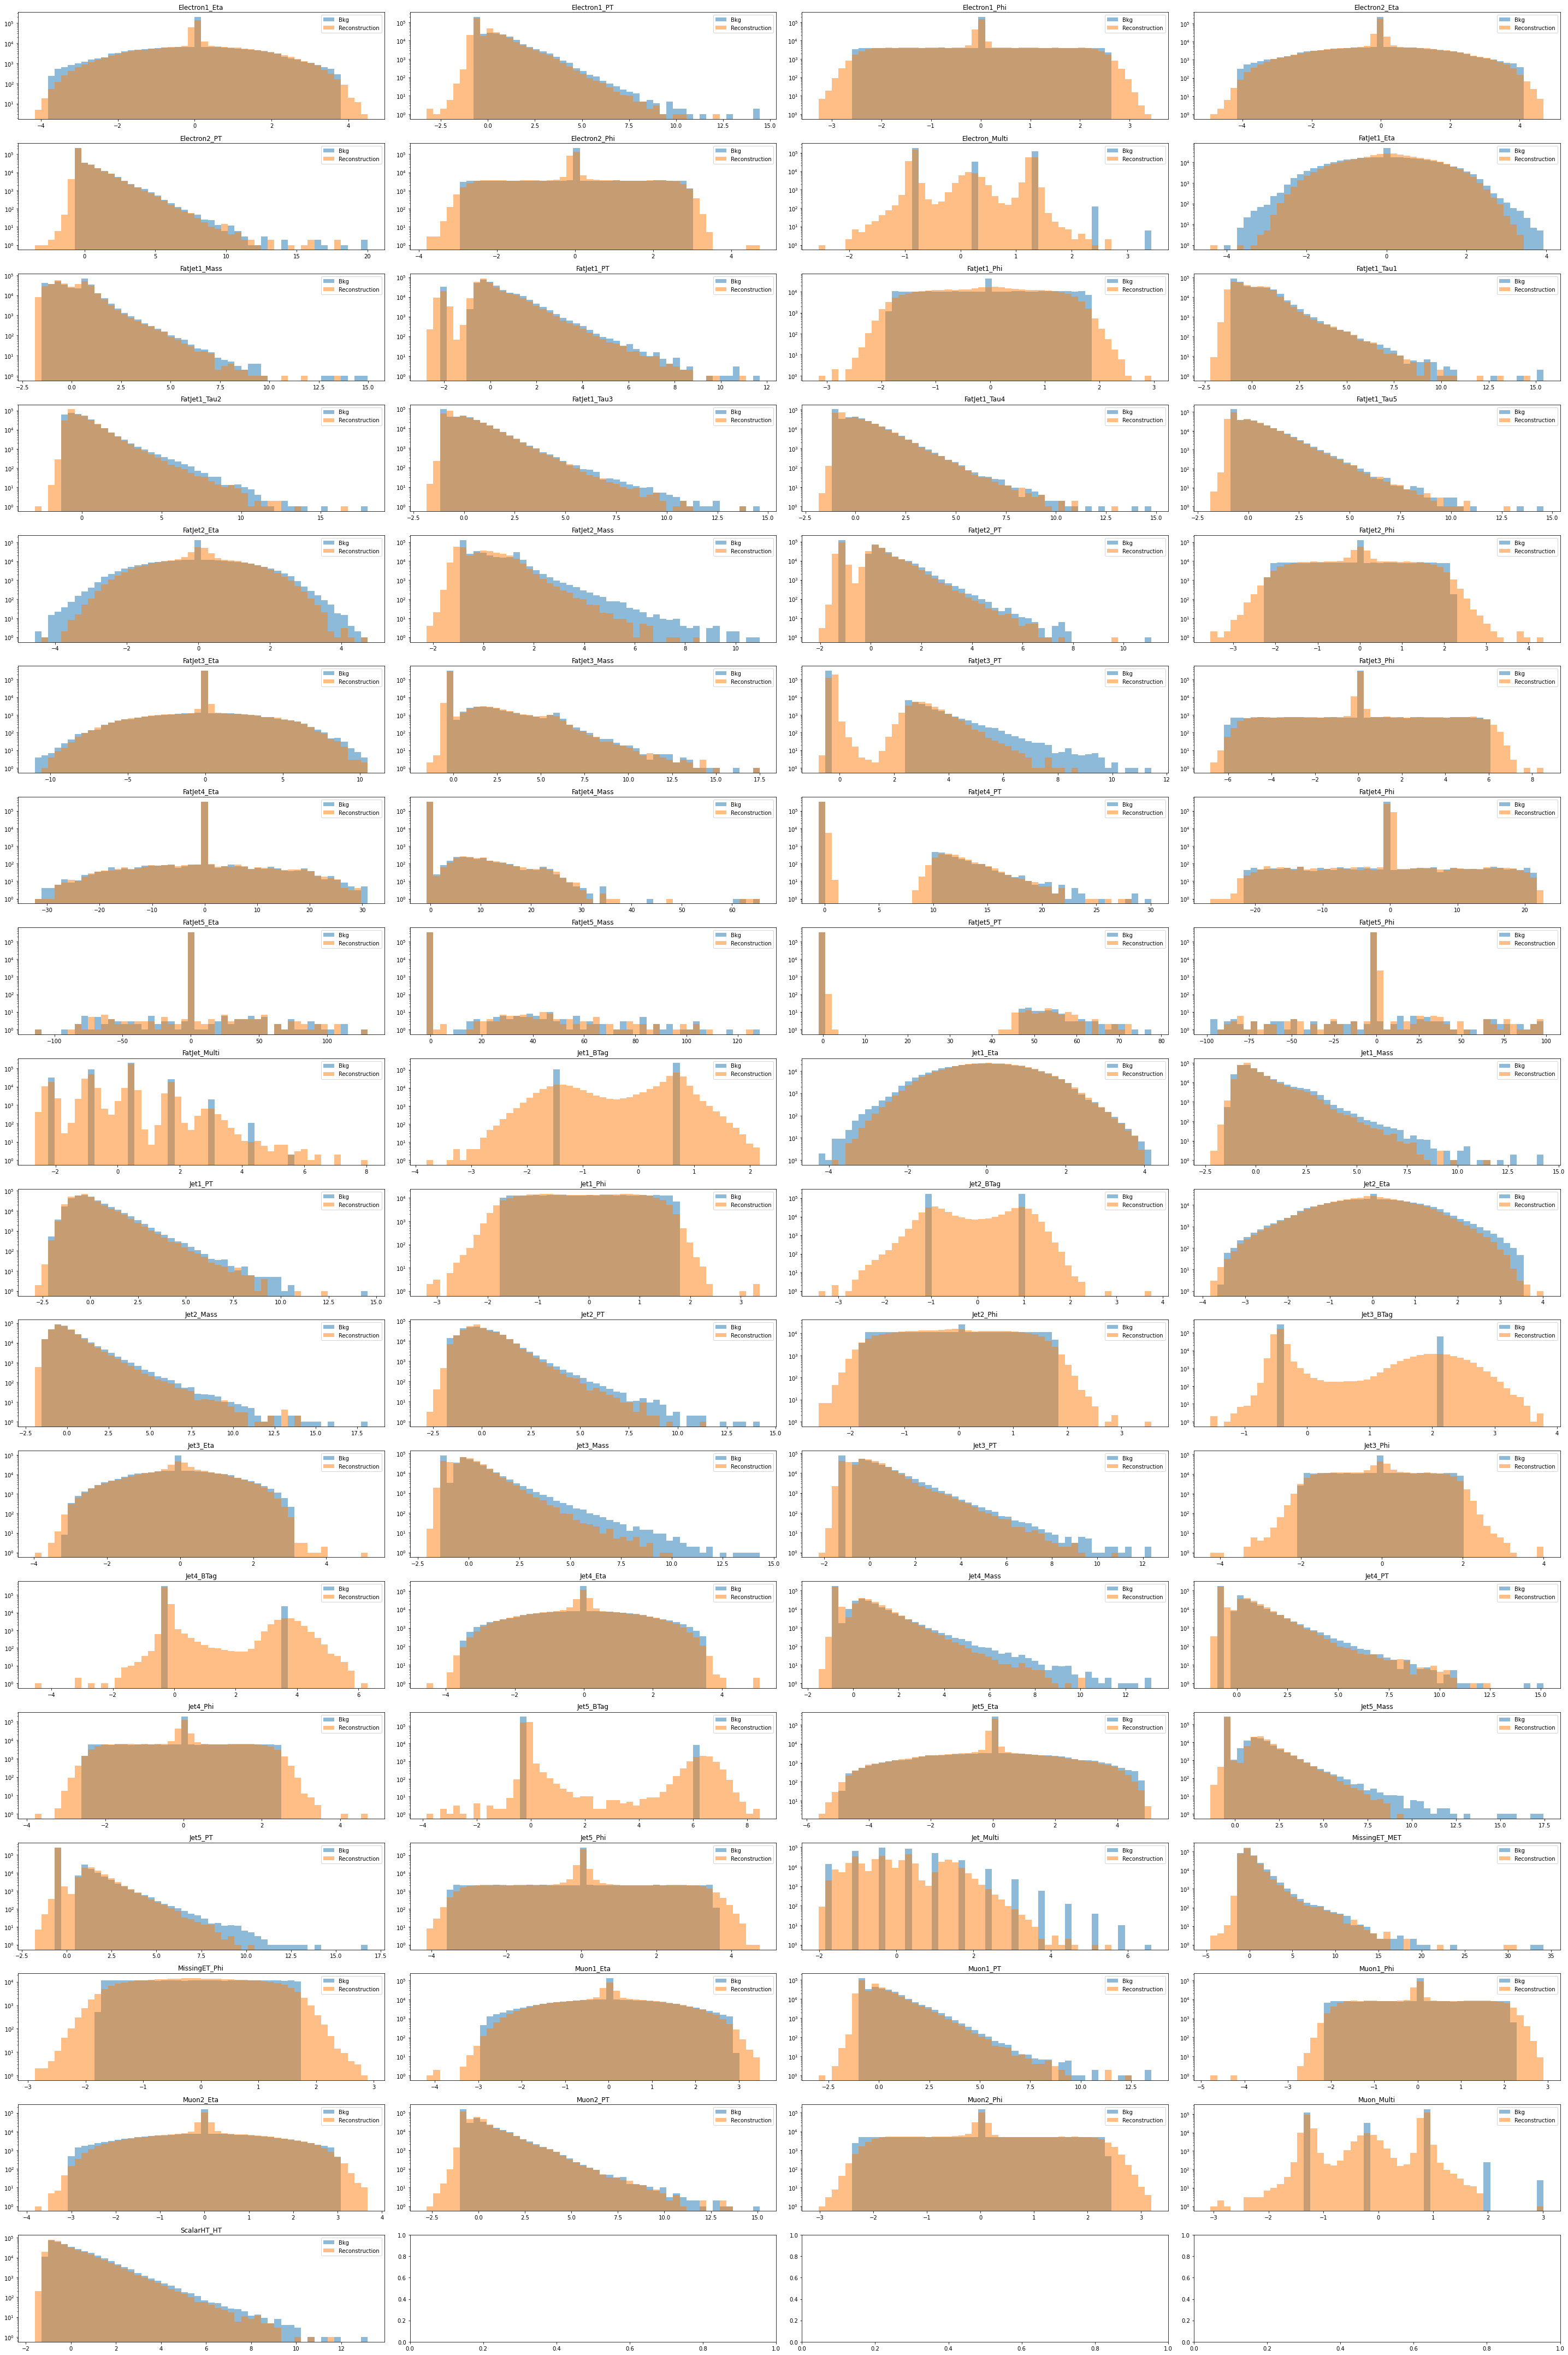

WD_SCORE: 0.08091123005497114
R2_SCORE: 0.9276352780381479


In [ ]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

In [ ]:
print("WD_Score:", compare_distributions_binned(bkg.to_numpy(), bkg_weights.to_numpy(), x_out, np.ones(bkg_weights.shape), bins=100))

## Plot error distributions and ROC Scores

Load data

In [ ]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()
# signal.drop(columns=['weights'], inplace=True)
signal['name'].unique()

array(['hg3000_hq1000.h5', 'wohg_hq1000.h5', 'hg3000_hq1200.h5',
       'wohg_hq1200.h5', 'fcnc.h5', 'hg3000_hq1400.h5', 'wohg_hq1400.h5'],
      dtype=object)

Plot

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
def plot_graphs3(data, bins=50, num_cols=4):

    # Plot creation
    features = list(data['name'].unique())

    #num_rows = int(np.ceil((len(list(features)) - 1) / num_cols)) +1
    #fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    #i= 0


    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        #row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        #i += 1

        # Input to the model
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])#[:100000]
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        # Pass input through model
        _, _, output, _ = model.test_step(sData)

        # Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    # Now we are going to find the maximum of all distributions
    max_of_dist = max(map(lambda x: max(x), distributions.values()))

    # Normalize the distributions
    # This way all values should be between 0 and one
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    # distributions =list(map(lambda x: x/max_of_dist, distributions))


    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        #x = x.replace(".h5", "")
        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range)

        # Plot rocs
        # ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    # PLOT ROC
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 
            score = score / max_of_dist

            #print(labels.shape, weights.shape, score.shape, x)
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            print(f"ROC SCORE for {x.replace('.h5', '')}:", 
                    roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights))

    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()

In [ ]:
data = pd.concat([signal, bkg])
del signal, bkg

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

ROC SCORE for hg3000_hq1000: 0.995729639211573
ROC SCORE for wohg_hq1000: 0.9958736391500019
ROC SCORE for hg3000_hq1200: 0.9961233552903412
ROC SCORE for wohg_hq1200: 0.9962715321212524
ROC SCORE for fcnc: 0.7155727895301054
ROC SCORE for hg3000_hq1400: 0.9961644353329592
ROC SCORE for wohg_hq1400: 0.9963787233705643
<ipython-input-15-ec75de003e3a>:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



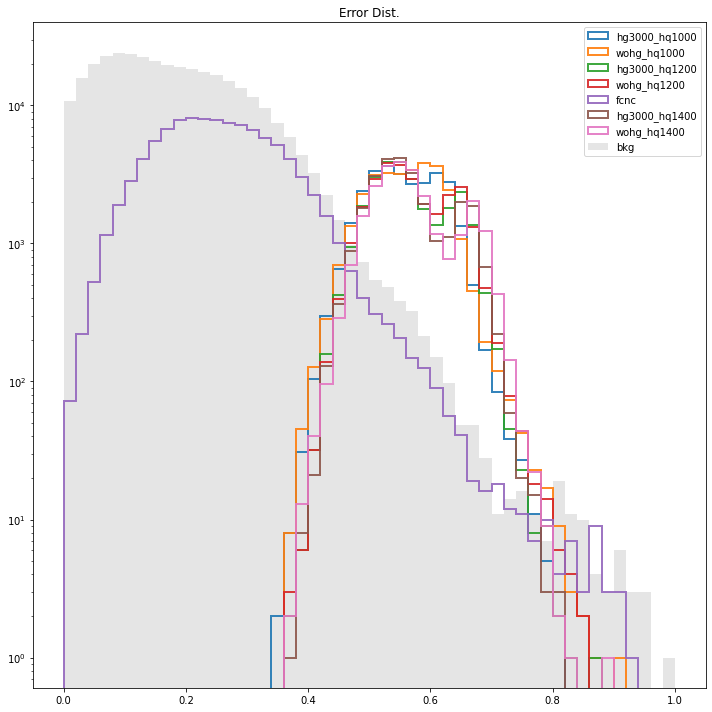

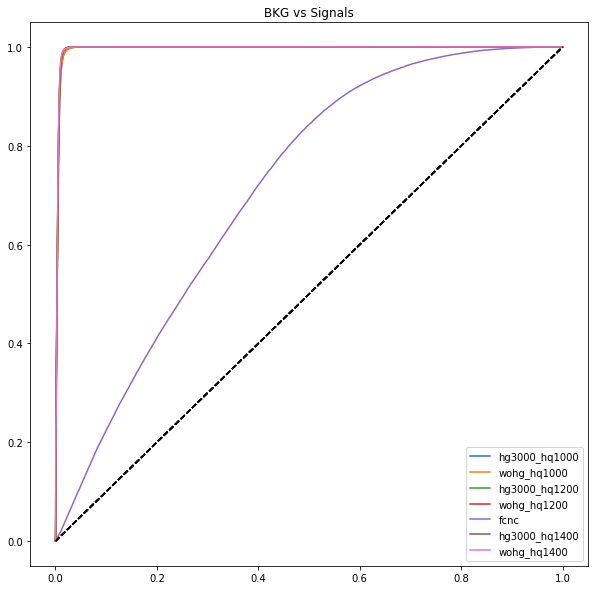

In [ ]:
plot_graphs3(data)

## Calculate ROC Score over HT Distribution

In [ ]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()

In [ ]:
# Normalizing the data
signal['ScalarHT_HT'] = signal['ScalarHT_HT'] - min(signal['ScalarHT_HT'])
bkg['ScalarHT_HT'] = bkg['ScalarHT_HT'] - min(bkg['ScalarHT_HT'])
max_value = max(max(signal['ScalarHT_HT']), max(bkg['ScalarHT_HT']))
bkg['ScalarHT_HT'] = bkg['ScalarHT_HT'] / max_value
signal['ScalarHT_HT'] = signal['ScalarHT_HT'] / max_value

ROC SCORE for hg3000_hq1000: 0.8980902245561665
ROC SCORE for wohg_hq1000: 0.901729274756001
ROC SCORE for hg3000_hq1200: 0.8961180846653122
ROC SCORE for wohg_hq1200: 0.9001556668363571
ROC SCORE for fcnc: 0.9121712701010867
ROC SCORE for hg3000_hq1400: 0.8959065842809264
ROC SCORE for wohg_hq1400: 0.8983267668496995
<ipython-input-20-0915d26f6014>:39: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



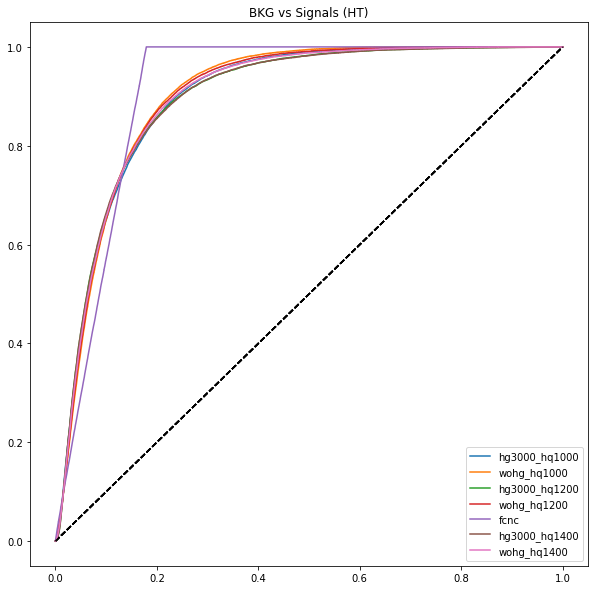

In [ ]:
fig_roc, ax_roc = plt.subplots(figsize=(10,10))
from sklearn.metrics import roc_auc_score, roc_curve
for x in signal['name'].unique():

    current_signal = signal[signal['name'] == x]['ScalarHT_HT']
    current_bkg = bkg['ScalarHT_HT']


    # Labels
    bkg_labels = np.zeros(current_bkg.shape[0]).astype(int)
    signal_labels = np.ones(current_signal.shape[0]).astype(int)
    labels = np.concatenate([bkg_labels, signal_labels])

    # Score
    score = pd.concat([bkg['ScalarHT_HT'], signal[signal['name'] == x]['ScalarHT_HT']])

    # Weights
    weights = pd.concat([
                        bkg['weights'], 
                        signal[signal['name'] == x]['weights']
                        ])


    fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
    ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
    ax_roc.plot([0,1],[0,1], 'k--')

    print(f"ROC SCORE for {x.replace('.h5', '')}:", 
            roc_auc_score(y_true=labels, 
            y_score=score,
            sample_weight=weights))

fig_roc.show()
ax_roc.set_title(f"BKG vs Signals (HT)")
ax_roc.legend()